### Pretrained RESNET Encoder with UNET Decoder
Using pre-trained weights to improve training speed.

Here, we use pre-trained RESNET weights to start the model.  We will only import the top of the network and add new layers at the bottom to reflect our desired output.

The strategy is to used the pretrained RESNET as the encoder and then train a UNET decoder.  We will use RESNET as the base and add the UNET decoder layers, then freeze the RESNET encoder and train the model.



![title](../VGG_with_Residual_Blocks.png)

Although this may be a little difficult to read, it shows an important progression.  Resnet is an evolution of VGG.  The first model on the left shows a 19-layer VGG model.  The second model shows a deeper VGG 34-layer model.

In general, as a network gets deeper, it has a greater capacity to identify more classes but will concurrently suffer an overtraing that will essentially create a network that performs identically to its shallower counterpart.  This wastes time building and training the network and creates slower inference times.  In this scenario, the network only learned as much as the shallow network offering no benefit. 

In order to resolve this, a "residual" pattern is added to the model in order to ensure that previous layer information is propagated to subsequent layers.  This is represented by the arrows between blocks in the model on the right.

This architecture is referred to as a Residual Network, or more commoly referred to as ResNet.


https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624

### Setup local Variables

In [1]:
import os, sys

project_root = "/Users/markmcdonald/Library/Mobile Documents/com~apple~CloudDocs/Harvard/CSCI_E25/Project/computer-vision-project"
data_dir     = '/Users/markmcdonald/Desktop/FashionDataSet'
train_dir    = os.path.join(data_dir, 'train')
images_file  = os.path.join(data_dir, 'train.csv' )
cat_file     = os.path.join(data_dir, 'label_descriptions.json' )
sys.path.append(project_root) # to capture FashtionDataset class
os.path.isdir(data_dir), os.path.isdir(train_dir), os.path.isfile(images_file), os.path.isfile(images_file)

(True, True, True, True)

In [2]:
import os
# fix libiomp5.dylib error for mac
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# OPTIONAL SETTING
# Here we override the keras backend env variable to use plaidml
# plaidml can make use of AMD GPUs 
# This assignment needs to be added before loading keras libraries

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

# to install plaidML, activate appropriate environment and then:
#   pip install -U plaidml-keras
#   plaidml-setup

In [3]:
# Keras imports

if os.environ.get("KERAS_BACKEND") == "plaidml.keras.backend":
    print("Loading PlaidML libraries for Keras.")
    import keras
    import keras.backend as K
    
    from keras.models import Model, load_model, model_from_json
    from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
    from keras.layers.core import Lambda, RepeatVector, Reshape
    from keras.layers.convolutional import Conv2D, Conv2DTranspose
    from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
    from keras.layers.merge import concatenate, add
    from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
    from keras.optimizers import Adam, SGD, RMSprop
    from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
    from keras.utils import to_categorical, Sequence
    from keras.layers import UpSampling2D
    from keras.preprocessing import image
    import keras.applications.resnet50 as ResNet50
    

else:
    print("Loading Tensorflow libraries for Keras.")
    import tensorflow as tf
    import tensorflow.keras.backend as K

    from tensorflow.python.keras.models import Model, load_model, model_from_json
    from tensorflow.python.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
    from tensorflow.python.keras.layers.core import Lambda, RepeatVector, Reshape
    from tensorflow.python.keras.layers.convolutional import Conv2D, Conv2DTranspose
    from tensorflow.python.keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
    from tensorflow.python.keras.layers.merge import concatenate, add
    from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
    from tensorflow.python.keras.optimizers import Adam, SGD
    from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
    from tensorflow.python.keras.utils import to_categorical, Sequence
    from tensorflow.python.keras.layers import UpSampling2D
    from tensorflow.python.keras.preprocessing import image
#     from tensorflow.python.keras.applications.resnet_v2 import ResNet152V2
    

Loading PlaidML libraries for Keras.


Using plaidml.keras.backend backend.


In [4]:
import warnings
warnings.filterwarnings('ignore')

import datetime, os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import seaborn as sns

# import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)

from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import skimage
import random
from sklearn.model_selection import train_test_split
import pickle
from skimage.transform import resize

import FashionUtils.FashionDataset as FashionDataset #import FashionDataset, create_datasets, load_dataset, save_dataset

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

# from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# from mrcnn.model import log
from mrcnn.visualize import display_images

%matplotlib inline 

## Load and Set Training Variables

In [5]:
# # NOTE: There are 300k line images in the full training list
# fash_train, fash_val = FashionDataset.create_datasets( images_file=images_file, 
#                                         cat_file=cat_file,
#                                         images_dir=train_dir,
#                                         split=0.95, 
#                                         limit=150000)

# FashionDataset.save_dataset(fash_train, os.path.join(data_dir, 'fashion_train_dataset_150k.pkl'))
# FashionDataset.save_dataset(fash_val,   os.path.join(data_dir, 'fashion_val_dataset_150k.pkl'))

In [6]:
fash_train = FashionDataset.load_dataset(os.path.join(data_dir, 'fashion_train_dataset_150k.pkl'))
fash_val   = FashionDataset.load_dataset(os.path.join(data_dir, 'fashion_val_dataset_150k.pkl'))

/Users/markmcdonald/Desktop/FashionDataSet/fashion_train_dataset_150k.pkl
/Users/markmcdonald/Desktop/FashionDataSet/fashion_val_dataset_150k.pkl


In [7]:
im_height = 128 # must be power of 2
im_width = 128  # must be power of 2
im_channels = 3 # must be 3
im_shape = (im_height, im_width, im_channels)
n_classes = len(fash_train.class_ids)

## Setup RESNET Models

## Unet Architecture
![title](../../unet/Unet_architecture.png)

In [8]:
resnet = ResNet50.ResNet50(include_top=False, 
                 weights='imagenet', 
                 input_tensor=Input(shape=im_shape), 
                 input_shape=im_shape, 
                 pooling=None, 
                 classes=1000)

INFO:plaidml:Opening device "metal_amd_radeon_rx_vega_64.0"


In [9]:
resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [20]:
# resnet_model, input_shape, output_shape, resnet_classes  = \
#       UNet_Resnet(input_shape=input_shape, resnet=ResNet50, 
#                    n_classes=n_classes)


def UNet_Resnet(input_img, 
         bn_enc:bool=False, 
         bn_dec:bool=True,
         contatenate:bool=True,
         init:str='glorot_uniform',
         activation='relu',
         n_classes=None,
         resnet=None): #keras.layers.ELU(alpha=1.0) keras.layers.LeakyReLU(alpha=0.3)
    
    
    def enc_layer(input_layer, depth, a=activation, i=init, p='same', bn=bn_enc):
        
        layer = Conv2D(depth, (3,3), padding=p, kernel_initializer = i)(input_layer)
        if bn:
            layer = BatchNormalization()(layer)
        layer = Activation(a)(layer)
        
        layer = Conv2D(depth, (3,3), padding=p, kernel_initializer = i)(input_layer)
        if bn:
            layer = BatchNormalization()(layer)
        layer = Activation(a)(layer)

        return MaxPooling2D(pool_size=(2,2))(layer), layer
    
    def dec_layer(input_layer, conc_layer, depth, a=activation, i=init, p='same', bn=bn_dec):
        
        layer = UpSampling2D((2,2))(input_layer)
        if concatenate:
            layer = concatenate([conc_layer,layer], axis=3)
        layer = Conv2D(depth, (3,3),padding=p,kernel_initializer = i)(layer)
        if bn:
            layer = BatchNormalization()(layer)
        layer = Activation(a)(layer)
        
        layer = Conv2D(depth, (3,3),padding=p,kernel_initializer = i)(layer)
        if bn:
            layer = BatchNormalization()(layer)
        layer = Activation(a)(layer)

        return layer
    
    encoder = None
    if resnet==None:
        # Encoder
        enc1_pool, enc1 = enc_layer(input_img,  64)
        enc2_pool, enc2 = enc_layer(enc1_pool, 128)
        enc3_pool, enc3 = enc_layer(enc2_pool, 256)
        enc4_pool, enc4 = enc_layer(enc3_pool, 512)
        
        encoder = Conv2D(1024, (3,3), padding='same', kernel_initializer = init)(enc4_pool)
        if bn_enc:
            encoder = BatchNormalization()(encoder)
        encoder = Activation(activation)(encoder)
        
    else:
        print("Using RESNET Backbone")
        resnet = resnet(include_top=False, 
                 weights='imagenet', 
                 input_tensor=Input(shape=im_shape), 
                 input_shape=im_shape, 
                 pooling=None, 
                 classes=1000)
        
        encoder = UpSampling2D((2,2))(resnet.get_output_at(-1))
        encoder = Conv2D(1024, (3,3), activation='relu', padding='same')(encoder)
        if bn_enc:
            encoder = BatchNormalization()(encoder)
        encoder = Activation(activation)(encoder)
        
        enc4 = UpSampling2D((4,4))(resnet.get_layer('bn5c_branch2b').output) #bn5c_branch2b
        enc3 = UpSampling2D((4,4))(resnet.get_layer('bn4f_branch2b').output) #bn4f_branch2b
        enc2 = UpSampling2D((8,8))(resnet.get_layer('bn4a_branch2b').output) #bn4a_branch2b
        enc1 = Conv2D(128, (3,3), padding='same')(UpSampling2D((4,4))(resnet.get_layer('bn2c_branch2c').output)) #bn2c_branch2c


    encoder = Conv2D(512, (3,3), activation=activation, padding='same', kernel_initializer = init)(encoder)
    if bn_enc:
        encoder = BatchNormalization()(encoder)
    encoder = Activation(activation)(encoder)

    # Decoder
    print ("encoder shape: ", encoder.shape)
    print ("enc4 shape: ", enc4.shape)
    print ("enc3 shape: ", enc3.shape)
    print ("enc2 shape: ", enc2.shape)
    print ("enc1 shape: ", enc1.shape)
    dec4 = dec_layer(encoder, enc4, 512)
    dec3 = dec_layer(dec4,    enc3, 256) 
    dec2 = dec_layer(dec3,    enc2, 128)
    dec1 = dec_layer(dec2,    enc1, 64)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(dec1)
    
    print("input  shape: ", resnet.input.shape.dims[1:])
    print("output shape: ", outputs.shape.dims[1:])

    # set up model
    model = Model(inputs=resnet.input, outputs=outputs)
    
    return model

## Setup Image Generators

In [21]:
class ImgMask_sequencer(Sequence):
    """
    Create batch generator based on Dataset object.
    Returns images and masks resize to target_size provided.
    """

    def __init__(self, dataset, 
                 batch_size:int=32, 
                 name:str=None, 
                 target_shape:tuple=(512,512,3),
                 color:bool=True):

        self.dataset      = dataset
        self.batch_size   = batch_size
        self.length       = len(self.dataset)
        self.num_batches  = int(np.floor(self.length / self.batch_size)) # no odd lots
        self.name         = name
        self.target_shape = target_shape
        self.classes      = self.dataset.source_class_ids['imaterialist']
        self.num_classes  = len(self.classes)
        self.color        = color

        print("Creating Generator '{}':".format(self.name))
        print("\tbatch size  : ", self.batch_size)
        print("\tlength      : ", self.length)
        print("\tnum batches : ", self.num_batches)
        print("\ttarget shape: ", self.target_shape)
        print("\tcolor       : ", self.color)
        
    def __len__(self):
        return self.num_batches
    
    def __iter__(self):
        batch_num = 0
        while true:
            i_batch, m_batch = self.__get_item__(batch_num)
            batch_num += 1
            if batch_num > self.num_batches-1:
                batch_num = 0
        yield i_batch, m_batch
    
    def __getitem__(self, idx):

        img_ids    = self.dataset.image_ids
       
        # get batch_num number of entries from dataset
        images, masks = [], []
        start = self.batch_size * idx
        end   = self.batch_size * (idx+1)
        
        if end>self.length-1:
            end = self.length-1
#             print("Curtailed: length:{}/end{}".format(self.length, end))

        for i in img_ids[start:end]:
            #load image and mask
            img  = self.dataset.load_image(i)
            mask, mask_classes = self.dataset.load_mask(i)
            
            # consider using modellib method
#             img, image_meta, class_ids, bbox, mask = modellib.load_image_gt(dataset, config, image_id, augment=True, use_mini_mask=True)
#             mask = utils.expand_mask(bbox, mask, img.shape)
            
            # convert color
            if not self.color:
                img = np.mean(img, axis=2)
                img = np.stack([img for i in range(3)], axis=2) # make 3-channel bw image
            
            if self.target_shape != None:
                # cropping to centermost area is critical
                # padded bars to fill square crop does not train
                
                # get max size centered square crop
                x_side, y_side, _ = img.shape
                if x_side < y_side:
                    y_min = int((y_side-x_side)/2)
                    img  = img [ : , y_min:y_min+x_side , :]
                    mask = mask[ : , y_min:y_min+x_side , :]
                if x_side > y_side:
                    x_min = int((x_side-y_side)/2)
                    img  = img [x_min:x_min+y_side , : , :]
                    mask = mask[x_min:x_min+y_side , : , :]
                # else x_dim==y_dim and is already square
                
                # resize with boxes to maintain scale
                img, window, scale, padding, crop  = utils.resize_image(img, max_dim=self.target_shape[0], mode='square')
                mask = utils.resize_mask(mask, scale, padding, crop) # resize to match image - input shape

                # crop tile in center of image and mask
                x = int((img.shape[0]-self.target_shape[0])/2)
                y = int((img.shape[1]-self.target_shape[1])/2)
                img = img[x:x+self.target_shape[0], y:y+self.target_shape[1]]
                mask = mask[x:x+self.target_shape[0], y:y+self.target_shape[1]]
                
            else:
                self.target_shape = img.shape

            # create stacked mask
            stacked_mask = np.zeros(shape=(self.target_shape[0], self.target_shape[1], self.num_classes))
            try:
                stacked_mask[:,:,mask_classes] = mask
            except Exception as e:
                print("\nError on image number: {}".format(i))
                print(e)
                continue
            
            # if there are two instances of same class - merge layers   
            cl_unique, cl_counts = np.unique(mask_classes, return_counts=True)
            dup_classes = cl_unique[cl_counts>1]
            if len(dup_classes) > 0:
                for d in dup_classes:
                    locations = np.where(mask_classes==d)[0]
                    stacked_mask[:,:,d] = (np.sum(mask[:,:,locations],axis=2))>0

            images.append(img/255) # /255
            masks.append(stacked_mask)
            
        try:    
            img_stack  = np.stack(images, axis=0) 
            mask_stack = np.stack(masks, axis=0)
        except Exception as e:
            print("Image number: {}".format(i))
            print("Start: {}  End: {}".format(start, end))
            print(e)

        return (img_stack, mask_stack)
    

### Test Generator

In [22]:
def get_unstacked_mask(stacked_mask, threshold:float=0.5):
    """
    Return a mask with as many channels as there are classes.
    Also returns the class id's for the channels returned.
    """
    
    def get_classids(stacked_mask):
        # get class id's from stacked mask
        class_ids = []
        for c in range(stacked_mask.shape[2]):
            if np.max(stacked_mask[:,:,c])>threshold:
                class_ids.append(c)

        return np.array(class_ids).astype(int)
    
    class_ids = get_classids(stacked_mask)
    unstacked_mask = stacked_mask[:,:,class_ids]
    
    return (unstacked_mask>threshold, class_ids)
    

Creating Generator 'Train Generator':
	batch size  :  1
	length      :  16452
	num batches :  16452
	target shape:  (128, 128)
	color       :  True


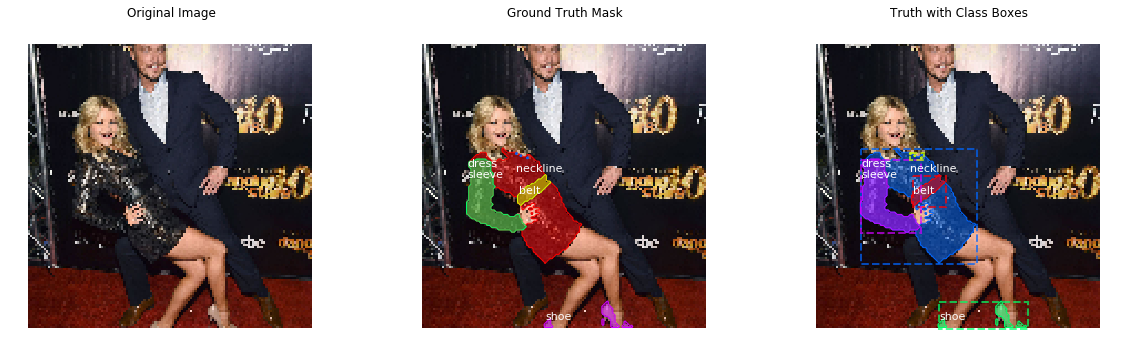

In [23]:
batch_size = 1
train_gen  = ImgMask_sequencer(fash_train, 
                                   batch_size=batch_size,
                                   name="Train Generator",
                                   target_shape=im_shape[0:2],
                                   color=True)

fix, ax = plt.subplots(ncols=3, figsize=(20,20), sharex=True, sharey=True)

rndidx = random.randint(0, len(fash_train))

test_image_batch, test_mask_batch = train_gen.__getitem__(rndidx)

test_image = test_image_batch[0]
test_mask  = test_mask_batch[0]

mask, class_ids = get_unstacked_mask(test_mask)
bbox = utils.extract_bboxes(mask)


ax[0].imshow(test_image)
ax[0].axis('off')
ax[0].set_title("Original Image")

visualize.display_instances(test_image*255, #*255
                            bbox, 
                            mask, 
                            class_ids, 
                            fash_val.class_names, 
                            figsize=(10,10),
                            show_bbox=False, show_mask=True,
                            ax=ax[1], title="Ground Truth Mask")

visualize.display_instances(test_image*255, #*255
                            bbox, 
                            mask, 
                            class_ids, 
                            fash_val.class_names, 
                            figsize=(10,10),
                            show_bbox=True, show_mask=True,
                            ax=ax[2], title="Truth with Class Boxes")




### Train Model

In [24]:
def train_resnet(  model,
                 train_data,
                 val_data,
                 epochs=10,
                 target_shape:tuple=(512,512,3), 
                 batch_size:int=128,
                 log_dir:str="./logs",
                 color:bool=True,
                 optimizer=Adam(),
                 initial_epoch=1):
    
    # custom loss function IOU
    def iou_loss(actual, predicted) -> float:
        return np.sum(np.abs(actual-(predicted>.5)))
    
    # custom accuracy
    def iou_acc(actual, predicted) -> float:
        
        matches = K.count_params(K.equal(actual, predicted))
        size = K.prod(target_shape[0:2], axis=None, keepdims=False)
        
        return matches/size
    

    # Setup callbacks
    callbacks = [
        EarlyStopping(patience=3, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
        ModelCheckpoint(os.path.join(log_dir,'model-unet-fashion.h5'), verbose=1, save_best_only=True, save_weights_only=False),
        TensorBoard(log_dir=log_dir, histogram_freq=0, batch_size=batch_size, update_freq='batch')
    ]

    # Get generators for training and validation
    train_gen  = ImgMask_sequencer(train_data, 
                                   batch_size=batch_size,
                                   name="Train Generator",
                                   target_shape=target_shape[0:2],
                                   color=color)

    val_gen    = ImgMask_sequencer(val_data, 
                                   batch_size=batch_size,
                                   name="Val Generator",
                                   target_shape=target_shape[0:2],
                                   color=color)

    model.compile(optimizer=optimizer, 
#                   loss=[iou_loss, "categorical_crossentropy", "binary_crossentropy", "acc", "accuracy"],
                  loss="categorical_crossentropy", # binary_crossentropy
                  metrics=["acc"]) #categorical_accuracy

    results = model.fit_generator(  train_gen,  
                                    epochs=epochs,
                                    callbacks=callbacks, 
                                    validation_data=val_gen,
                                    shuffle=True,
                                    initial_epoch=initial_epoch)
    
    return results

In [25]:
resnet_model  = UNet_Resnet(input_img=im_shape, 
                            resnet=ResNet50.ResNet50, 
                            n_classes=n_classes)

Using RESNET Backbone
encoder shape:  Shape(dtype=<DType.FLOAT32: 50>, dims=(<tile.Value Operation UINT64()>, 8, 8, 512))
enc4 shape:  Shape(dtype=<DType.FLOAT32: 50>, dims=(<tile.Value Operation UINT64()>, 16, 16, 512))
enc3 shape:  Shape(dtype=<DType.FLOAT32: 50>, dims=(<tile.Value Operation UINT64()>, 32, 32, 256))
enc2 shape:  Shape(dtype=<DType.FLOAT32: 50>, dims=(<tile.Value Operation UINT64()>, 64, 64, 256))
enc1 shape:  Shape(dtype=<DType.FLOAT32: 50>, dims=(<tile.Value Operation UINT64()>, 128, 128, 128))
input  shape:  (128, 128, 3)
output shape:  (128, 128, 47)


### Set Trainable Layers

In [26]:
# set trainable layers - conv 5 and after
istrainable = False
for layer in resnet_model.layers:
    
    if layer.name=='res5a_branch2a': #start of block 5
        istrainable = True
    
    layer.trainable = istrainable


In [27]:
for layer in resnet_model.layers:
    print(layer.name, layer.trainable)

input_5 False
conv1_pad False
conv1 False
bn_conv1 False
activation_200 False
pool1_pad False
max_pooling2d_5 False
res2a_branch2a False
bn2a_branch2a False
activation_201 False
res2a_branch2b False
bn2a_branch2b False
activation_202 False
res2a_branch2c False
res2a_branch1 False
bn2a_branch2c False
bn2a_branch1 False
add_65 False
activation_203 False
res2b_branch2a False
bn2b_branch2a False
activation_204 False
res2b_branch2b False
bn2b_branch2b False
activation_205 False
res2b_branch2c False
bn2b_branch2c False
add_66 False
activation_206 False
res2c_branch2a False
bn2c_branch2a False
activation_207 False
res2c_branch2b False
bn2c_branch2b False
activation_208 False
res2c_branch2c False
bn2c_branch2c False
add_67 False
activation_209 False
res3a_branch2a False
bn3a_branch2a False
activation_210 False
res3a_branch2b False
bn3a_branch2b False
activation_211 False
res3a_branch2c False
res3a_branch1 False
bn3a_branch2c False
bn3a_branch1 False
add_68 False
activation_212 False
res3b_bran

In [28]:
logs_base_dir = os.path.join(data_dir, 'resnet_logs')
log_dir=os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),"-2")
os.path.isdir(logs_base_dir)

True

In [ ]:
# Train Model
batch_size=4
epochs=5

# epochs
history = train_resnet(resnet_model,
                     fash_train,
                     fash_val,
                     epochs=epochs,
                     target_shape=im_shape, 
                     batch_size=batch_size,
                     log_dir=log_dir,
                     color=True,
                     initial_epoch=0, # 0 indexed values
                     optimizer=RMSprop(lr=.02)) #SGD(lr=.01, momentum=.99) RMSprop(lr=.01) Adam(lr=.01)

print("Training Complete.  Accuracy: {}".format(history.history['acc'][-1]))
resnet_model.save(os.path.join(log_dir,'model-resnet-fashion-5epochs-batchsize4-lr02.h5'))


Creating Generator 'Train Generator':
	batch size  :  4
	length      :  16452
	num batches :  4113
	target shape:  (128, 128)
	color       :  True
Creating Generator 'Val Generator':
	batch size  :  4
	length      :  4113
	num batches :  1028
	target shape:  (128, 128)
	color       :  True
Epoch 1/5


INFO:plaidml:Analyzing Ops: 407 of 3289 operations complete
INFO:plaidml:Analyzing Ops: 833 of 3289 operations complete
INFO:plaidml:Analyzing Ops: 1321 of 3289 operations complete
INFO:plaidml:Analyzing Ops: 1574 of 3289 operations complete
INFO:plaidml:Analyzing Ops: 1645 of 3289 operations complete
INFO:plaidml:Analyzing Ops: 1682 of 3289 operations complete
INFO:plaidml:Analyzing Ops: 1755 of 3289 operations complete


1226/4113 [=======>......................] - ETA: 56:20 - loss: 0.7433 - acc: 0.0891
Error on image number: 6136
shape mismatch: value array of shape (96,128,9) could not be broadcast to indexing result of shape (9,128,128)


INFO:plaidml:Analyzing Ops: 269 of 3289 operations complete
INFO:plaidml:Analyzing Ops: 774 of 3289 operations complete
INFO:plaidml:Analyzing Ops: 1265 of 3289 operations complete
INFO:plaidml:Analyzing Ops: 1513 of 3289 operations complete
INFO:plaidml:Analyzing Ops: 1609 of 3289 operations complete
INFO:plaidml:Analyzing Ops: 1683 of 3289 operations complete
INFO:plaidml:Analyzing Ops: 1755 of 3289 operations complete


2288/4113 [===============>..............] - ETA: 35:16 - loss: 0.7061 - acc: 0.0984

Creating Generator 'Train Generator':
	batch size  :  1
	length      :  4113
	num batches :  4113
	target shape:  (128, 128)
	color       :  True


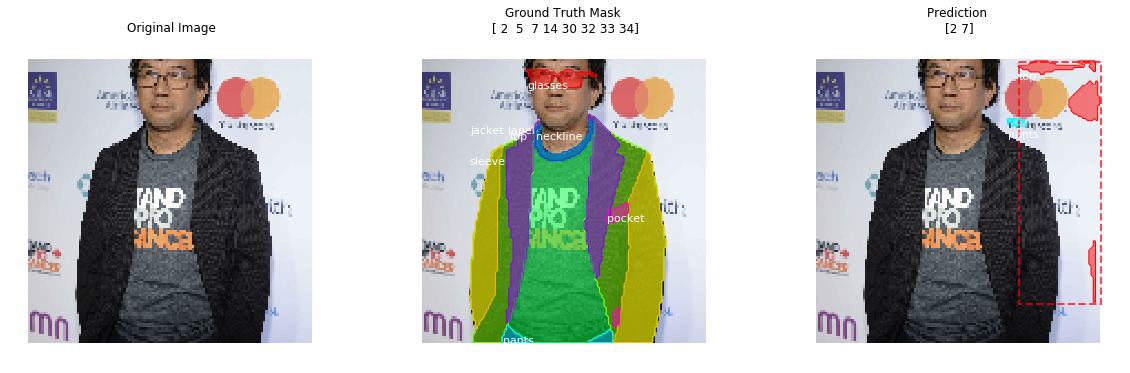

In [165]:
batch_size = 1
val_gen  = ImgMask_sequencer(  fash_val, 
                                 batch_size=batch_size,
                                 name="Train Generator",
                                 target_shape=im_shape[0:2],
                                 color=True)

rndidx = random.randint(0, len(fash_val))
test_image_batch, test_mask_batch = val_gen.__getitem__(rndidx)
test_image = test_image_batch[0]
test_mask  = test_mask_batch[0]

mask, class_ids = get_unstacked_mask(test_mask)
bbox = utils.extract_bboxes(mask)

fix, ax = plt.subplots(ncols=3, figsize=(20,20), sharex=True, sharey=True)

ax[0].imshow(test_image)
ax[0].axis('off')
ax[0].set_title("Original Image")

visualize.display_instances(test_image*255, 
                            bbox, 
                            mask, 
                            class_ids, 
                            fash_val.class_names, 
                            figsize=(10,10),
                            show_bbox=False, show_mask=True,
                            ax=ax[1], title="Ground Truth Mask \n{}".format(class_ids))

pred_mask_batch = resnet_model.predict(test_image_batch)
p_mask, p_class_ids = get_unstacked_mask(pred_mask_batch[0], threshold=0.5)
p_bbox = utils.extract_bboxes(p_mask)
visualize.display_instances(test_image*255, 
                            p_bbox, 
                            p_mask>.5, 
                            p_class_ids, 
                            fash_val.class_names, 
                            figsize=(10,10),
                            show_bbox=True, show_mask=True,
                            ax=ax[2], title="Prediction \n{}".format(p_class_ids))




In [158]:

resnet_model.save(os.path.join(log_dir,'model_resenet-unet-fashion-2epochs-batchsize4-poor.h5'))
